In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
import umap

/anuj/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def compute_bins(position_range, bin_len=480):
    """ Compute bin edges for given spike times.

        Args:
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms which is 480 samples of spikes)
            sampling_period - sampling period in ms (default 1s/20kHz = 0.05ms)
        Return:
            List of bin edges (in ms), total number of bins
    """
    
    bin_num = np.ceil( (position_range[-1] - position_range[0]) / bin_len).astype(int)
    bin_edges = np.arange(position_range[0], position_range[-1]+bin_len, bin_len)
    
    return bin_edges, bin_num

def bins_from_spike_times(spike_times, position_range, bin_len=480, dtype=np.uint16, dense_loading=True, return_mat_type=np.array):
    """ Bin given spike times, each bin contains total number of spikes.

        Args:
            spike_times - list of spike times per neuron (list of iterables, pre-sorted in a non-descending order)
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms)
            sampling_period - sampling period in ms (default 1s/24kHz)  1/480
            dtype - dtype to use for bins, default np.uint16 (np.uint8 would use less memory, but can store only up to 256 spikes per bin)
            dense_loading - if True (default) load data into a dense np.ndarray then convert to a `return_mat_type` (fast), if False load into a sparse matrix (slow, but memory efficient)
            return_mat_type - type of matrix to be returned (default is sparse `csc_matrix` for efficient storage and relatively fast column slicing)
        Return:
            Matrix with spike count per bin ((neuron num, time bins), `return_mat_type`)
    """
    # leave this two lines here in case we find non-sorted spikes (.res files)
    # maxes = [np.max(st) if len(st) > 0 else 0 for st in spike_times]
    # last_spike_time = to_ms(np.max(maxes), sampling_period)  # in ms
    bin_edges, bin_num = compute_bins(position_range, bin_len)

    if dense_loading:
        # fastest loading (due to indexing), but requires a lot of memory
        binned_data = np.empty((len(spike_times), bin_num), dtype=np.uint16)
    else:
        # lil_matrix is fast for loading rows, convert later to return_mat_type
        binned_data = lil_matrix((len(spike_times), bin_num), dtype=np.uint16)
    print((bin_edges.shape), binned_data.shape)
    for n, st in enumerate(spike_times):
        hist = np.histogram(st, bins=bin_edges)[0]
        binned_data[n] = hist

    return return_mat_type(binned_data), bin_edges, bin_num

In [121]:
path = "./mJC283-20220909/"

clu_path = path + 'JC283-20220909_training1.clu'
res_path = path + 'JC283-20220909_training1.res'

des_path =  path + 'JC283-20220909.des'

whl_path = path + "JC283-20220909_training1.whl"

pos = pd.read_csv(   
                    whl_path ,
                    sep=" ",
                    header=None,
                    names=["x1","y1"]
)

with open(des_path, 'r') as file:
    des = np.array(file.read().split())
    
with open(res_path, 'r') as file:
    res = np.array(file.read().split())
    
pos["x1"],pos["y1"] = jcl.utils.interpolate_position(pos["x1"], pos["y1"], unknown_val=1023)

(2870,) (117, 2869)
(117, 117)


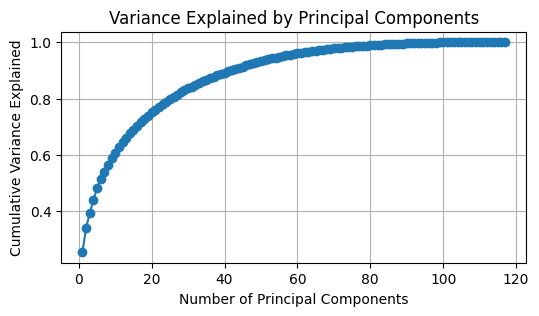

In [122]:
spike_times = jcl.load.spike_times_from_res_and_clu( res_path, clu_path, exclude_clusters=[0, 1] )

st = []

for i in np.where(des =='pp')[0]:
    st.append(spike_times[i])
    
binned_data, bin_edges, bin_num = bins_from_spike_times( 
                            st,
                            (  0, int(res[-1])+5000),
                            bin_len= 20000
)

# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


# #####CAN USE BIN EDGES INSTEAD OF BIN CENTERS IN THIS AND THEN YOU NEED TO SKIP THE LAST POSITION I THINK


# position = np.stack([pos["x1"],pos["y1"]])
# position


data = binned_data * 5
row_means = np.mean(data, axis=1)
row_stds = np.std(data, axis=1)

# Z = (data - row_means[:, np.newaxis]) / row_stds[:, np.newaxis]

Z = (data - row_means[:, np.newaxis]) 

# 2. Calculate the Covariance Matrix
covariance_matrix = np.cov(Z)
print(covariance_matrix.shape)

# 3. Compute the Eigenvectors and Eigenvalues
eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)

# 4. Sort Eigenvalues
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

# 5. Calculate Variance Explained
total_variance = np.sum(sorted_eigenvalues)
variance_explained = sorted_eigenvalues / total_variance

# 6. Visualize Variance Explained
plt.figure(figsize = (6,3))
plt.plot(range(1, len(binned_data) + 1), np.cumsum(variance_explained), marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.grid()
plt.show()


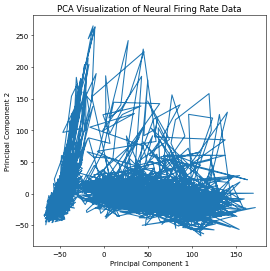

In [112]:
pca = PCA(n_components=40)
projected_data = pca.fit_transform(Z.T) 

plt.figure(figsize = (6, 6), dpi = 50)
plt.plot(projected_data[:, 0], projected_data[:, 1] )
# plt.scatter(projected_data[21000:25000, 1], projected_data[21000:25000, 2] , color = "r")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Neural Firing Rate Data')
plt.show()

In [113]:
# 2. Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_components=2)  # Reduce to 2D for visualization
embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP

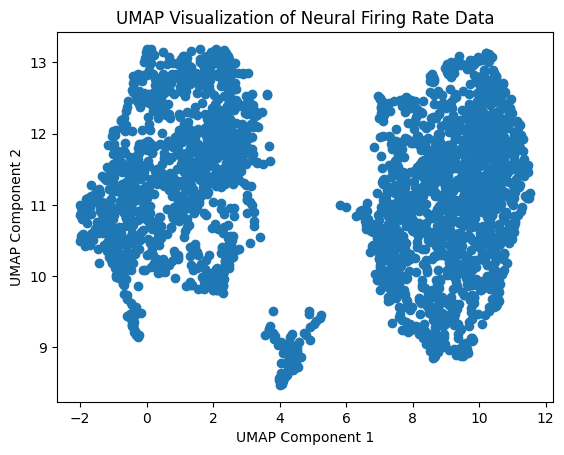

In [114]:
# 3. Visualize the Reduced Data
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Neural Firing Rate Data')
plt.show()

(2870,) (69, 2869)


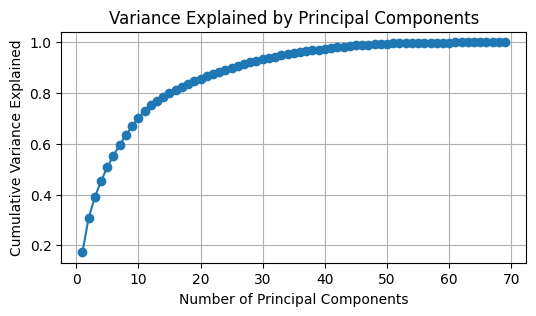

In [119]:
path = "./mJC283-20220920/"

clu_path = path + 'JC283-20220920_training1.clu'
res_path = path + 'JC283-20220920_training1.res'

des_path =  path + 'JC283-20220920.des'

with open(des_path, 'r') as file:
    des = np.array(file.read().split())
    
spike_times = jcl.load.spike_times_from_res_and_clu( res_path, clu_path, exclude_clusters=[0, 1] )

st = []

for i in np.where(des =='pp')[0]:
    st.append(spike_times[i])
    
binned_data, bin_edges, bin_num = bins_from_spike_times( 
                            st,
                            (  0, int(res[-1])+5000),
                            bin_len= 20000
)

data = binned_data * 5
row_means = np.mean(data, axis=1)
row_stds = np.std(data, axis=1)

Z = (data - row_means[:, np.newaxis]) 

# 2. Calculate the Covariance Matrix
covariance_matrix = np.cov(Z)
# 3. Compute the Eigenvectors and Eigenvalues
eigenvalues, eigenvector = np.linalg.eig(covariance_matrix)
# 4. Sort Eigenvalues
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
# 5. Calculate Variance Explained
total_variance = np.sum(sorted_eigenvalues)
variance_explained = sorted_eigenvalues / total_variance

# 6. Visualize Variance Explained
plt.figure(figsize = (6,3))
plt.plot(range(1, len(binned_data) + 1), np.cumsum(variance_explained), marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.grid()
plt.show()

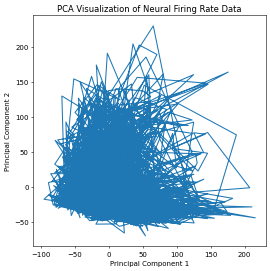

In [116]:
pca = PCA(n_components=30)
projected_data = pca.fit_transform(Z.T) 

plt.figure(figsize = (6, 6), dpi = 50)
plt.plot(projected_data[:, 0], projected_data[:, 1] )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Neural Firing Rate Data')
plt.show()

In [117]:
# 2. Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_components=2)  # Reduce to 2D for visualization
embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP

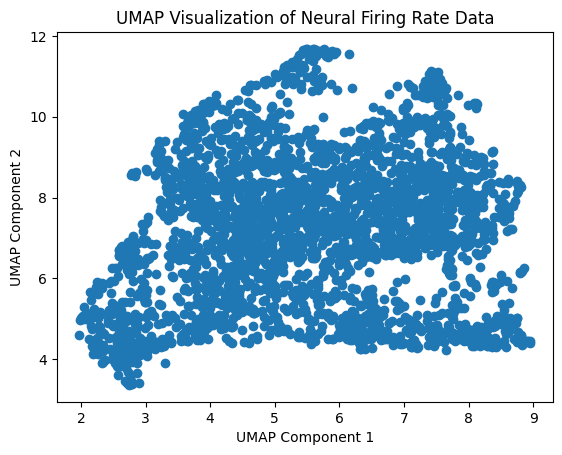

In [118]:
# 3. Visualize the Reduced Data
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Neural Firing Rate Data')
plt.show()

In [16]:
def speed_filter(position, bin_len, speed_thr, speed_violation = 90):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat
        Return:
            positions speed filtered with low speed set to 0, low speed position indices
    """
    assert speed_thr is not None
    window_size = 20
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_pos = position.copy()
    smooth_pos[0,:] = savgol_filter(position[0,:], window_size, poly_degree)
    smooth_pos[1,:] = savgol_filter(position[1,:], window_size, poly_degree)
    
    speed = np.array( jcl.utils.calc_speed(smooth_pos.T,bin_len) )
#     print(speed.shape)
    speed_violation_index = np.where(speed > speed_violation)[0]
    for i in speed_violation_index:
        speed[i]= np.mean(speed[i-10:i])
        
    # Window size and polynomial degree for the Savitzky-Golay filter
    window_size = 20
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_speed = savgol_filter(speed, window_size, poly_degree)
    speed_l_idx = smooth_speed < speed_thr
    
    speed_filtered_positions = smooth_pos.copy().T
    
#     print(speed_filtered_positions.shape)
    speed_filtered_positions[speed_l_idx] = [0,0]
    return speed_filtered_positions, speed_l_idx

speed_filtered_positions, low_speed_index = speed_filter(pos, 20, 5)

for i in range((binned_data).shape[0]):    
    ##### The occupancy adds +bin len for each position ie. it is in the actual time domain to find the time there.
    #so if you give 480 it counts it as 480 ms whereas everywhere else in the code it was using it to index etc.
    # so use 20 ms here as the 480 sample points actually corresponds to the 20ms

    binned_data[i, :][low_speed_index] = 0

InvalidIndexError: (0, slice(None, None, None))

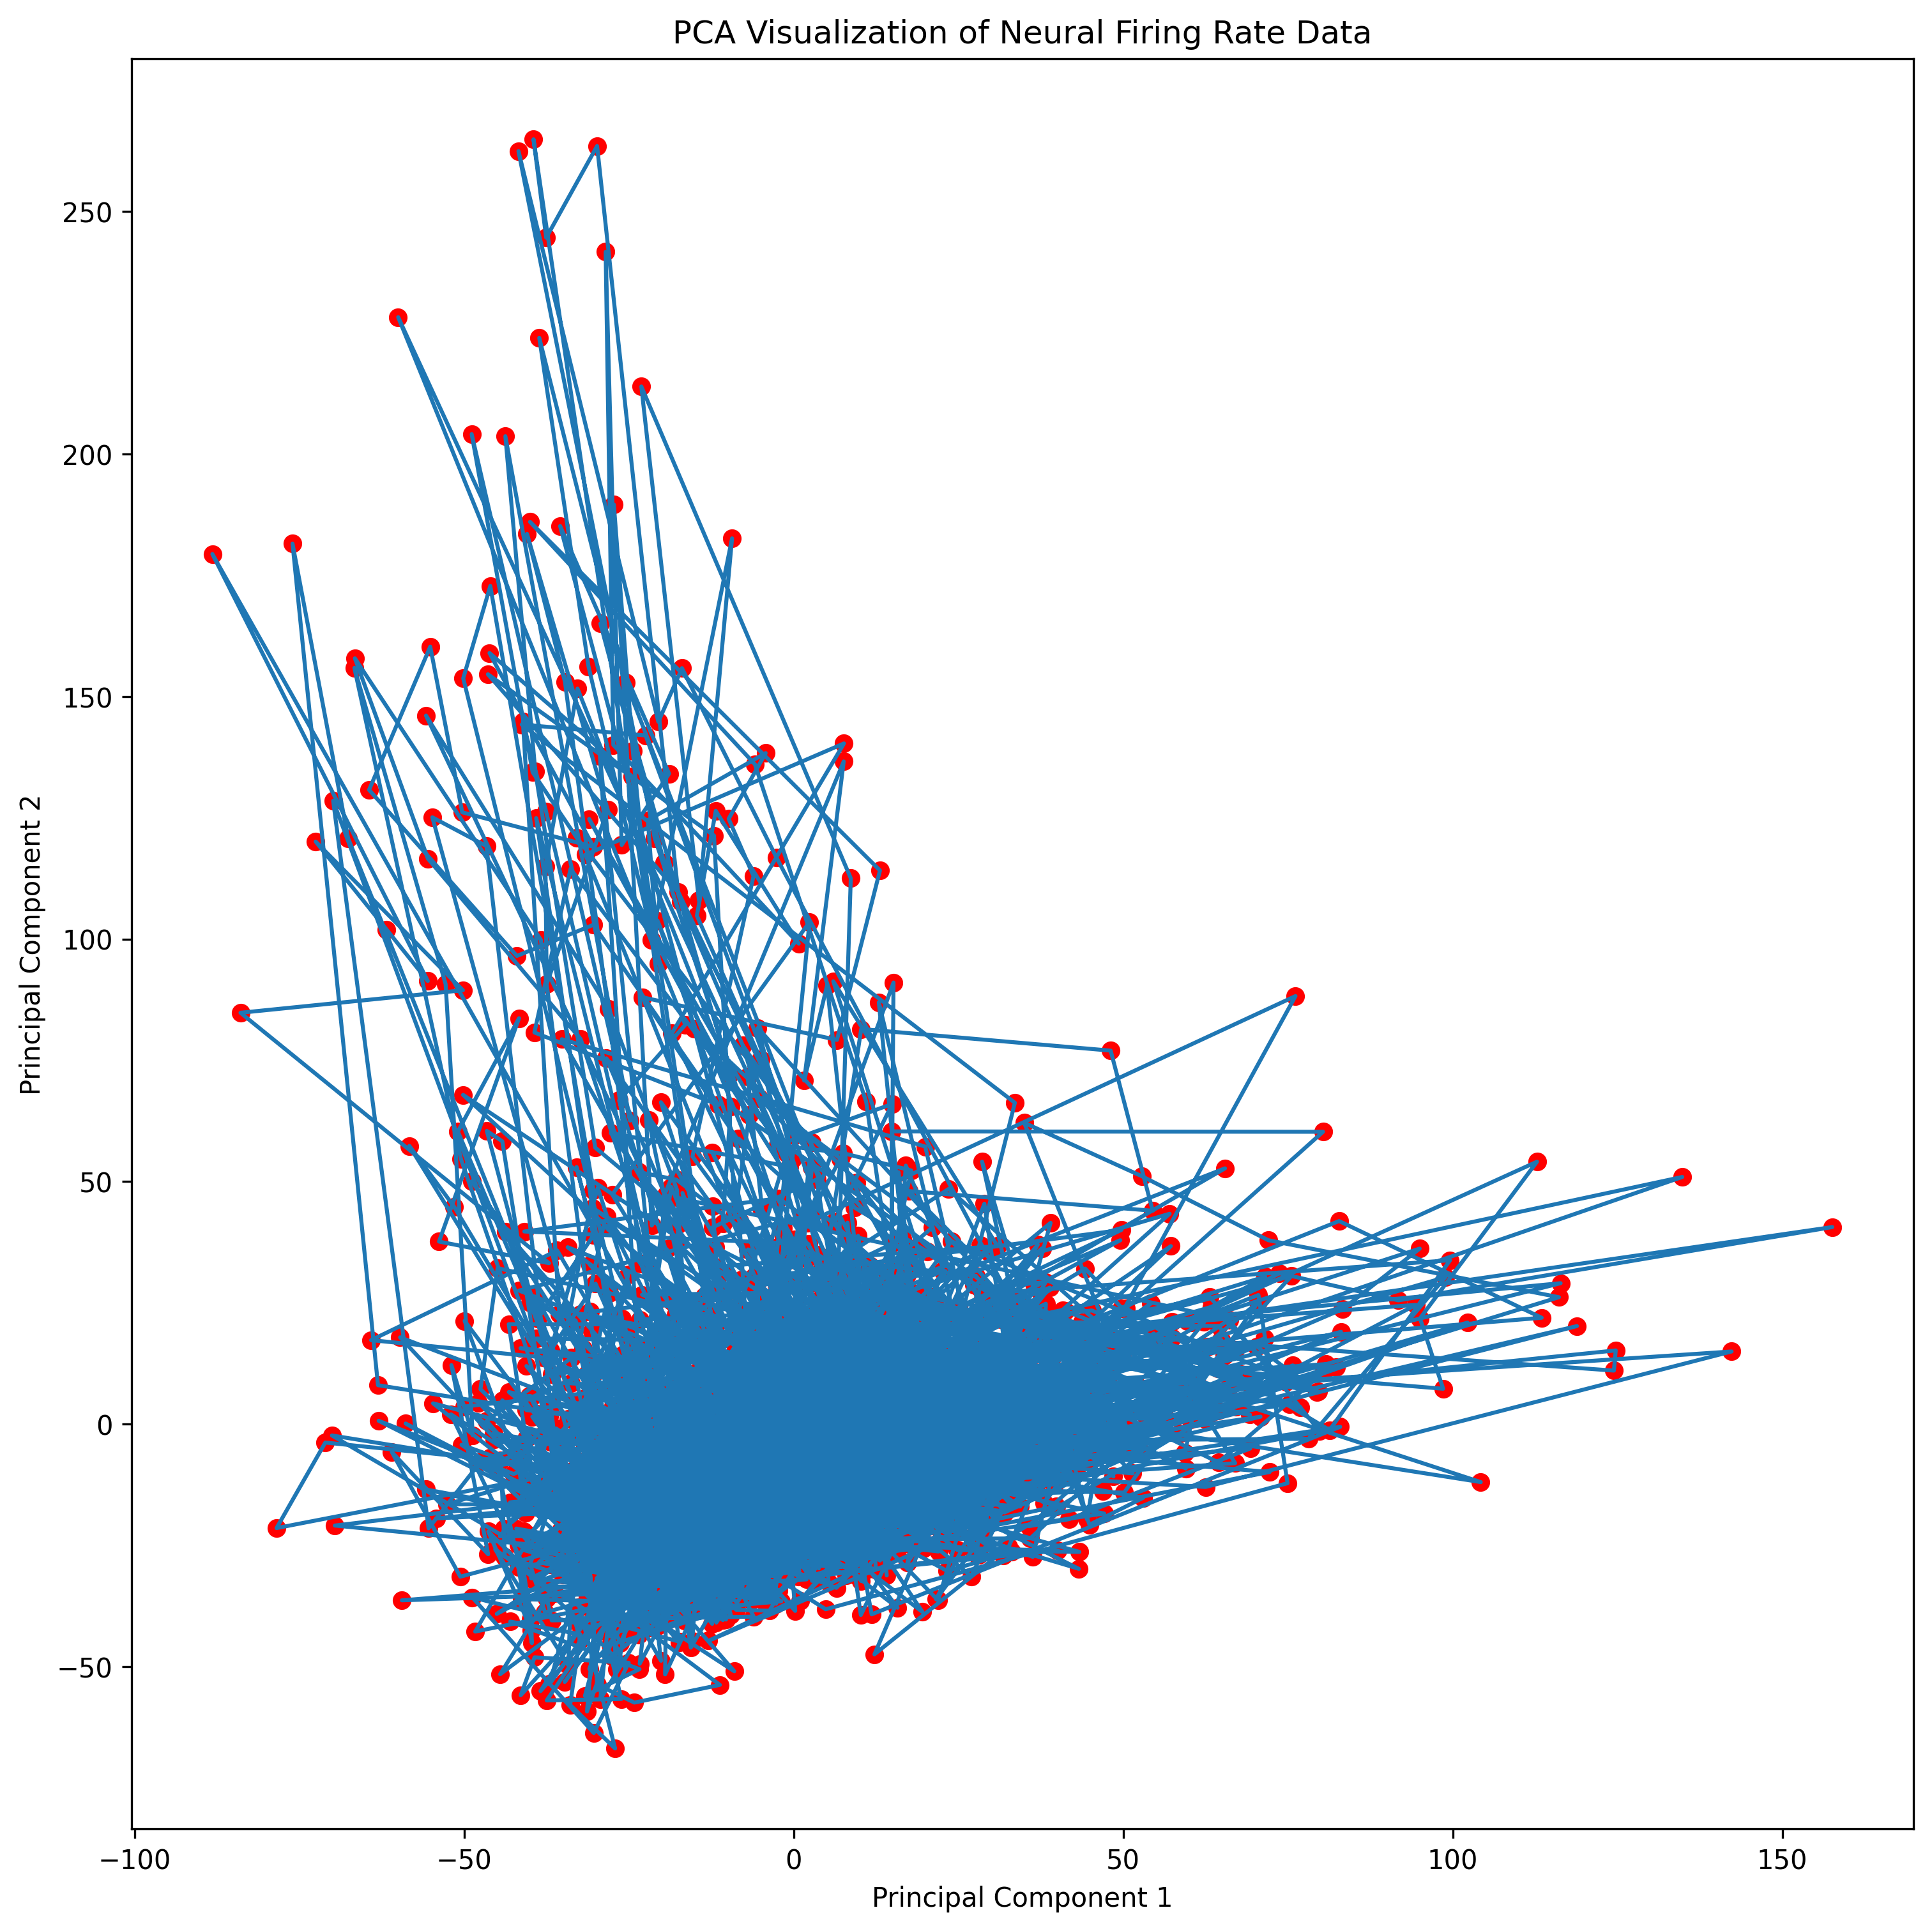

In [43]:
plt.figure(figsize = (12, 12), dpi = 300)
plt.plot(projected_data[:,2], projected_data[:,1] )
plt.scatter(projected_data[:,2], projected_data[:,1] , color = "r")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Neural Firing Rate Data')
plt.show()

In [51]:

data_range = (70, 130)

# Define a function to assign smooth colors to subregions
def assign_smooth_colors(x, y):
    # Normalize your data to the range [0, 1]
    x_normalized = (x - data_range[0]) / (data_range[1] - data_range[0])
    y_normalized = (y - data_range[0]) / (data_range[1] - data_range[0])

    # Interpolate the color based on the position within the subregion
    color = cm.jet((x_normalized+ y_normalized)/2 )

    return color

# Apply the color assignment function to your data
assigned_colors = [assign_smooth_colors(x, y) for x, y in position]

plt.scatter(position[:,0],position[:,1],c=assigned_colors)
plt.show()

# 3. Visualize the Reduced Data
plt.scatter(embedding[57000:61000, 0], embedding[57000:61000, 1],c=assigned_colors[57000:61000])
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of Neural Firing Rate Data')
plt.show()

NameError: name 'position' is not defined

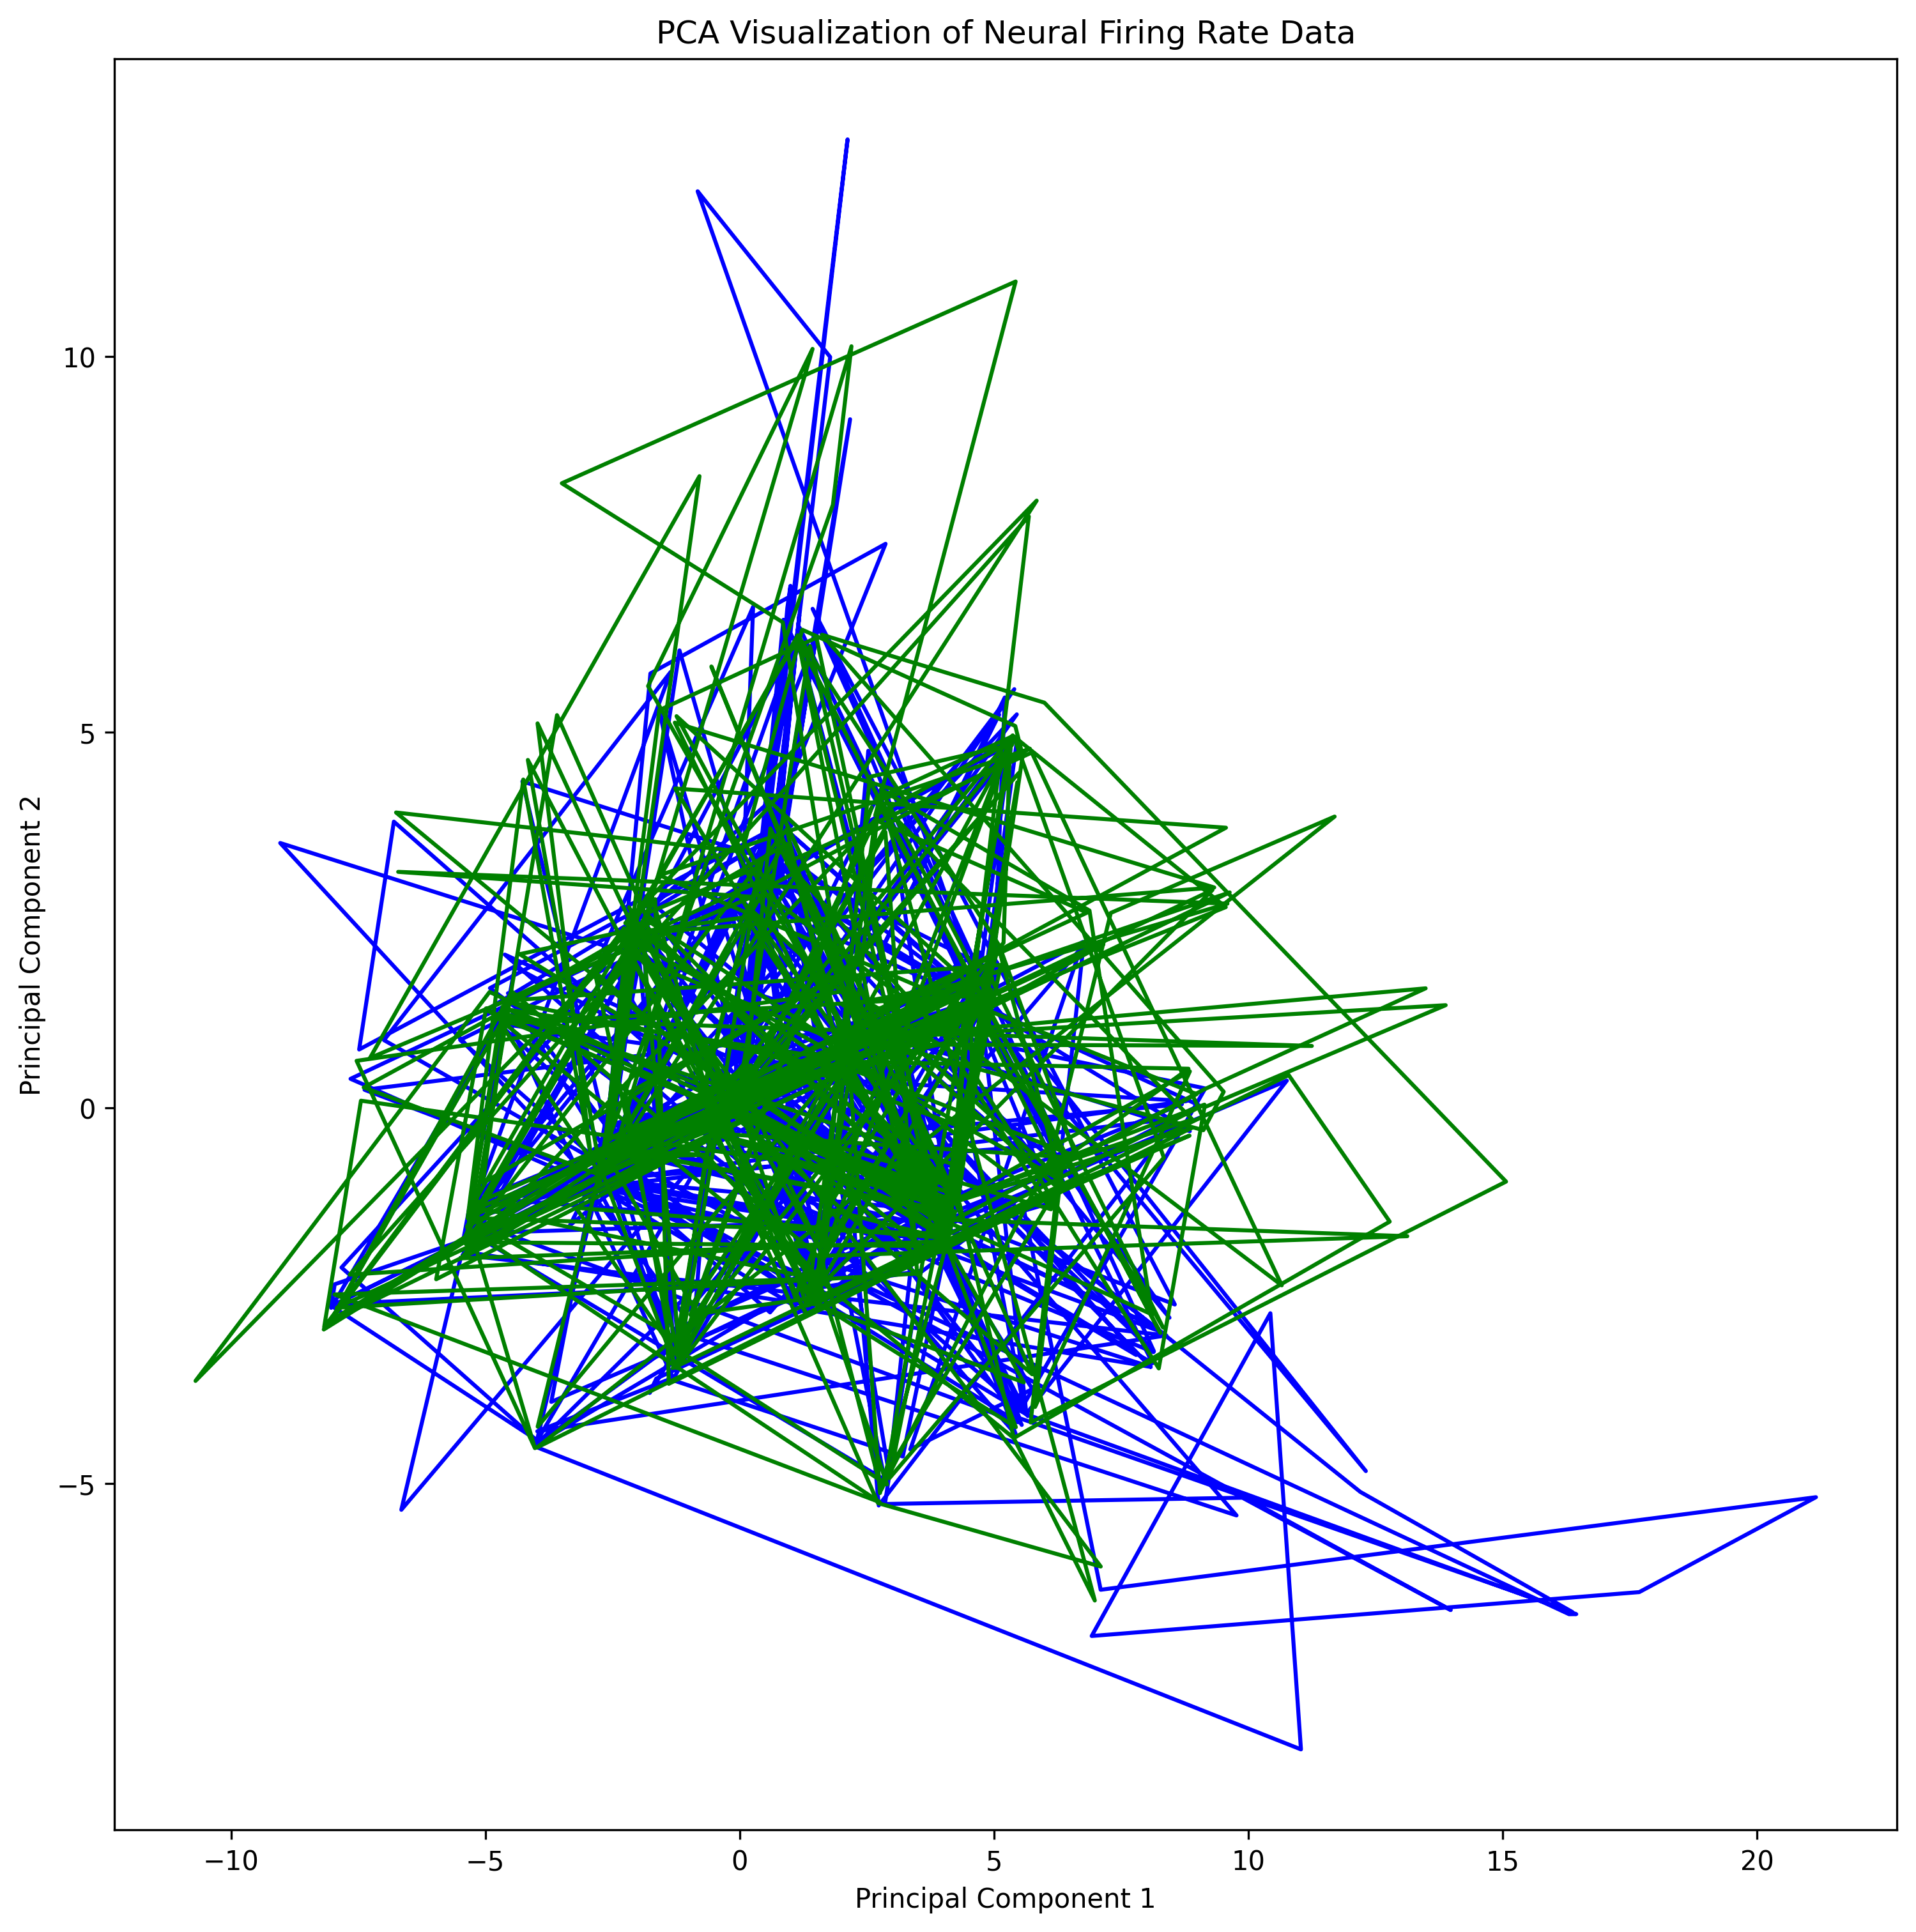

In [81]:
plt.figure(figsize = (12, 12), dpi = 300)
plt.plot(projected_data[57000:58000, 1], projected_data[57000:58000, 2] ,  c=    'blue'      )
# plt.plot(projected_data[58000:59000, 1], projected_data[58000:59000, 2]  ,  c=    'red'    )
plt.plot(projected_data[59000:60000, 1], projected_data[59000:60000, 2]  ,   c=    'green'   )
# plt.plot(projected_data[60000:61000, 1], projected_data[60000:61000, 2]  ,    c=    'yellow' )

# plt.scatter(projected_data[57000:61000, 1], projected_data[57000:61000, 2],c='r')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Neural Firing Rate Data')
plt.show()

(0.0, 160.0)

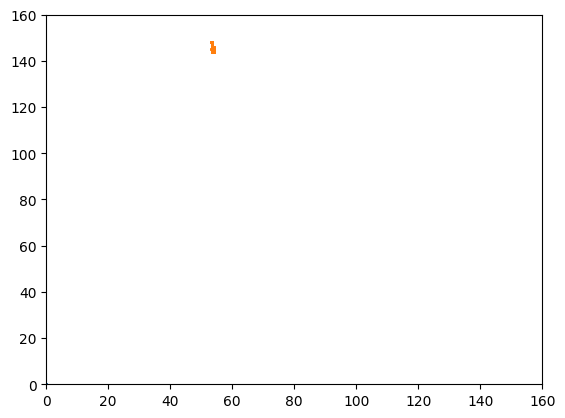

In [66]:
plt.scatter(speed_filtered_positions[58000:59000, 0], speed_filtered_positions[58000:59000, 1],s=1)
plt.scatter(position[58000:59000, 0], position[58000:59000, 1],s=1)
plt.xlim([0,160])
plt.ylim([0,160])

In [52]:
# 2. Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_components=2)  # Reduce to 2D for visualization
embedding = reducer.fit_transform(Z.T)  # Transpose the data for UMAP

ValueError: 'c' argument has 153177 elements, which is inconsistent with 'x' and 'y' with size 40.

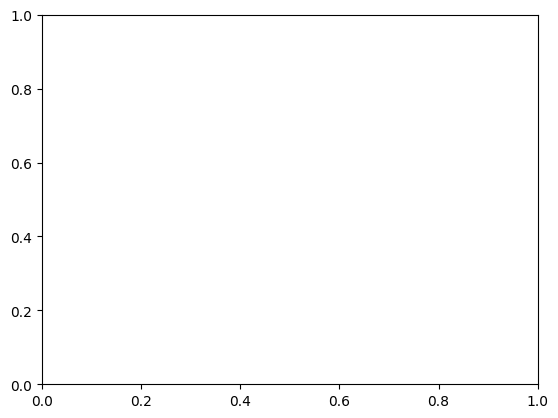

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import cm




# Perform PCA on your data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Z)

# Visualize the PCA results with assigned smooth colors using the "jet" colormap
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=assigned_colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Smooth Colors (jet colormap)')
plt.colorbar()  # Add a colorbar to show the color scale
plt.show()


(0.0, 160.0)

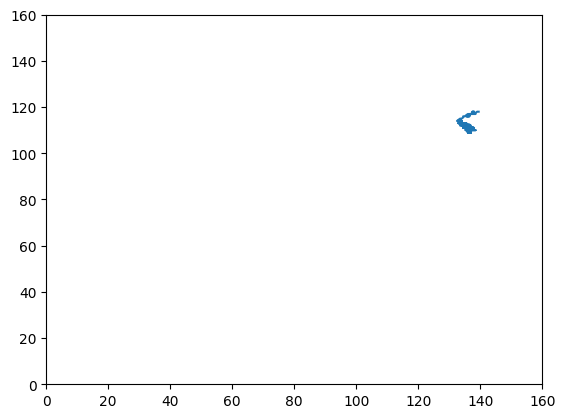

In [82]:
plt.plot(position[21000:25000,0],position[21000:25000,1])
plt.xlim([0,160])
plt.ylim([0,160])